# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Finding** 
***

## Model Code

In [28]:
### Import the libraries

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
### Camera Calibration - based on Chessboard

#%matplotlib inline
%matplotlib qt

# prepare object points
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        
        #cv2.startWindowThread()
        cv2.imshow('img', img)
        cv2.waitKey(500)
        #plt.imshow(img)

cv2.destroyAllWindows()

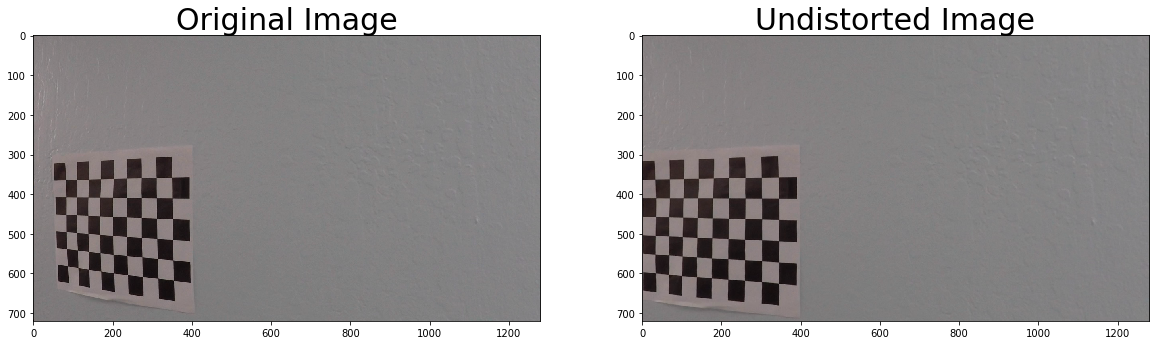

In [3]:
### Distortion Correction Parameters + Test image

%matplotlib inline

# Test undistortion on an image
img = cv2.imread('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/calibration_test.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/calibration_test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
### Select a sample image and undistort the picture

image = mpimg.imread('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

cv2.imwrite('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/pipeline_images/test4_undistorted.jpg',image)

True

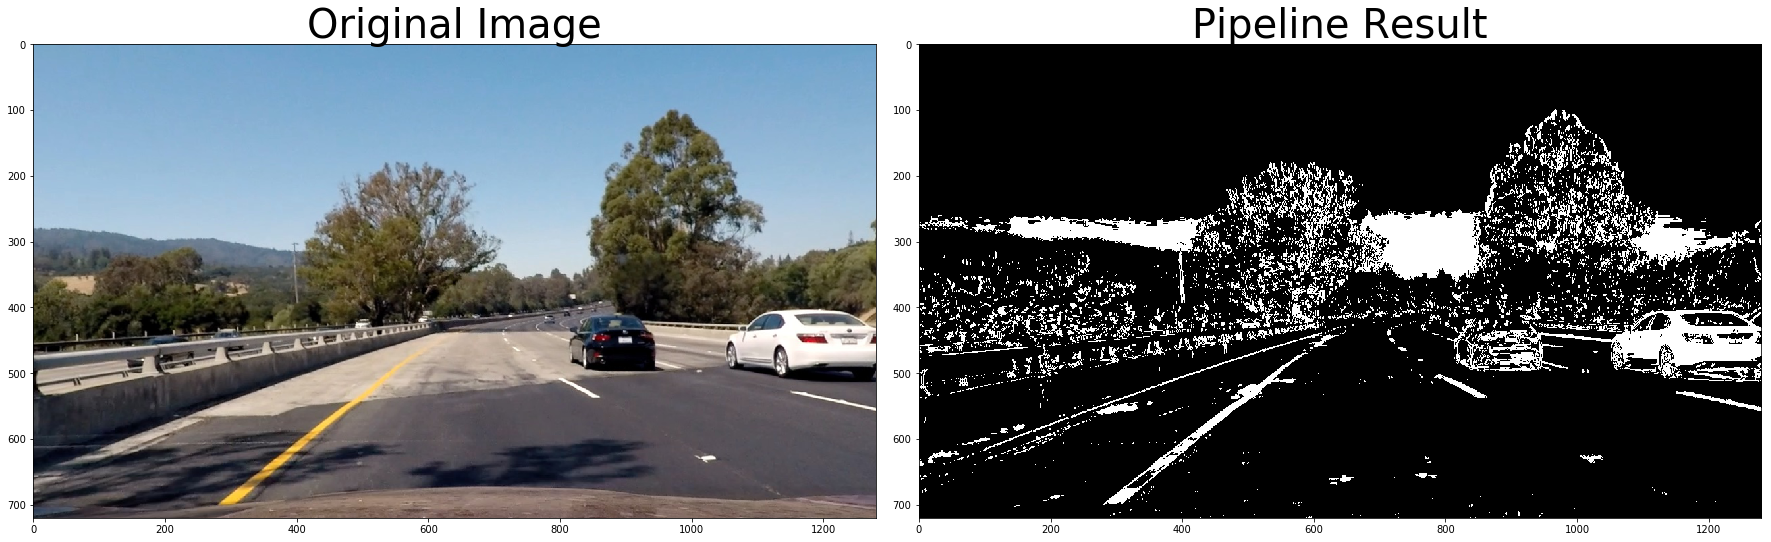

In [5]:
### Color & Gradient Threshold - ALTERNATIVE 1

%matplotlib inline

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), h_thresh=(15, 100), l_thresh=(200, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # First threshold for s color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Second threshold for h color channel
    #h_binary = np.zeros_like(h_channel)
    #h_binary[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Second threshold for l color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    combined = np.zeros_like(s_binary)
    #combined[((sxbinary == 1) | (s_binary == 1) | (h_binary == 1))] = 1
    combined[((sxbinary == 1) | (s_binary == 1) | (l_binary == 1))] = 1
    
    return combined
      
result = pipeline(image, s_thresh=(170, 255), h_thresh=(18, 100), l_thresh=(200, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.imsave('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/pipeline_images/test4_gradient.jpg',result, cmap='gray')

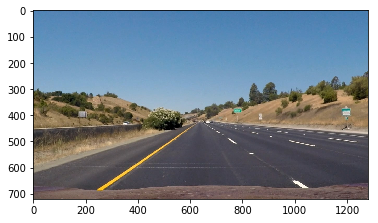

In [11]:
### Determine the object points for the transform - OPTIONAL - No need to run this code

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

image = mpimg.imread('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')

plt.imshow(image)

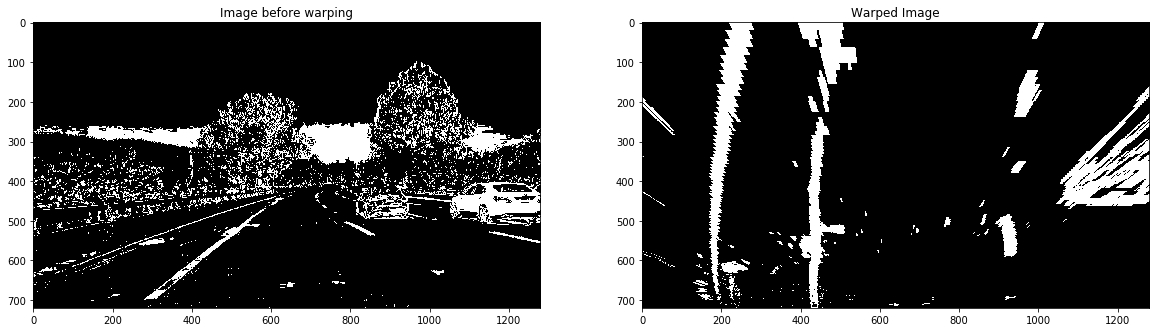

In [6]:
### Perspective Transform

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def warp(image):
    
    #calculate image size
    img_size = (image.shape[1], image.shape[0])
    
    #select source vertices for the transform
    #src = np.float32([[725,475], [1040,680], [260,680], [557,475]])
    src = np.float32([[743,485], [1040,680], [260,680], [546,485]])
    
    offset = 400
    dst = np.float32([[img_size[0]-offset, offset], 
            [img_size[0]-offset, img_size[1]], 
            [offset, img_size[1]],
            [offset, offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped, M, Minv


%matplotlib inline

warped_im, M, Minv = warp(result)

warped_im_combined = np.zeros_like(warped_im)
warped_im_combined[(warped_im > 0)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(result, cmap='gray')
ax1.set_title('Image before warping')
ax2.imshow(warped_im_combined, cmap='gray')
ax2.set_title('Warped Image')

plt.imsave('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/pipeline_images/test4_warped.jpg',warped_im_combined, cmap='gray')

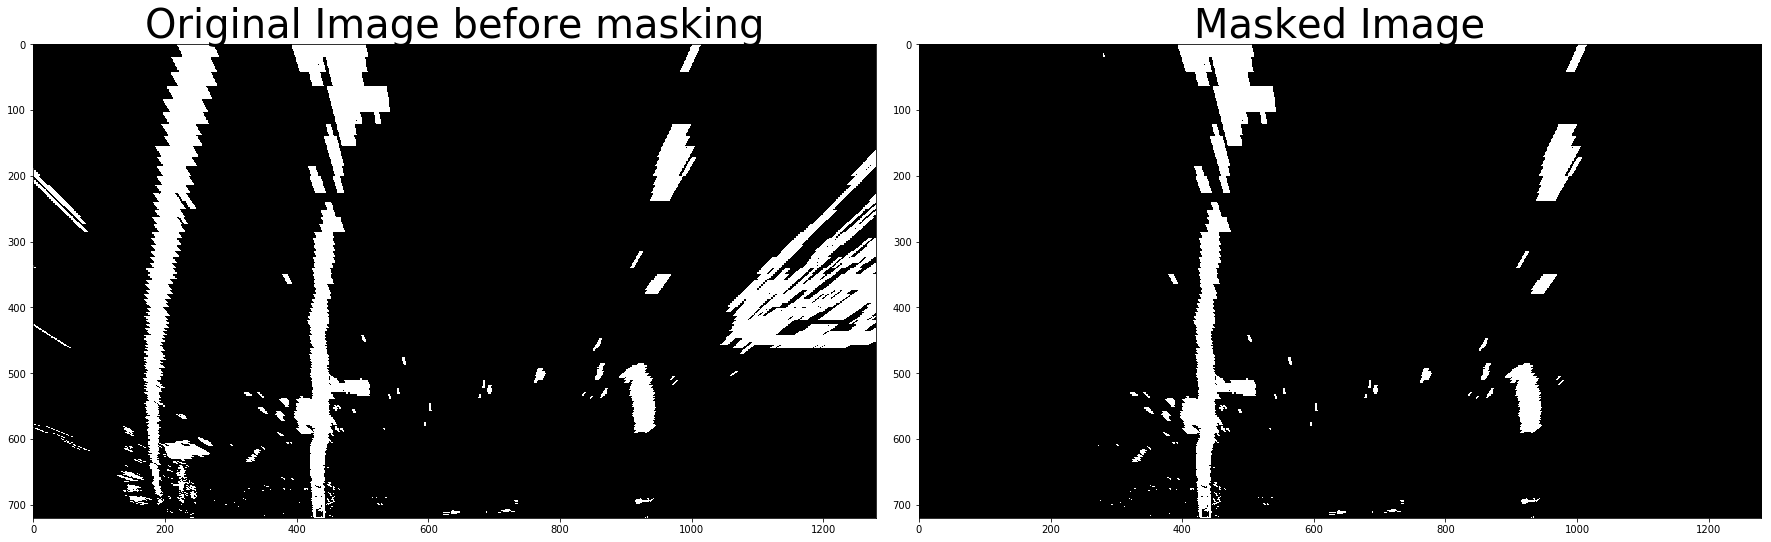

In [7]:
### Mask applied to an image

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = result.shape
#vertices = np.array([[(30,imshape[0]),(1.47*imshape[1]/3, imshape[0]/1.7), (1.53*imshape[1]/3, imshape[0]/1.7), (imshape[1]-30,imshape[0])]], dtype=np.int32)
#vertices = np.array([[(30,imshape[0]),(0.45*imshape[1], imshape[0]/1.7), (0.55*imshape[1], imshape[0]/1.7), (imshape[1]-30,imshape[0])]], dtype=np.int32)
#vertices = np.array([[(30,imshape[0]),(0.47*imshape[1], imshape[0]/1.7), (0.53*imshape[1], imshape[0]/1.7), (imshape[1]-30,imshape[0])]], dtype=np.int32)

#vertices = np.array([[(30,imshape[0]),(0.42*imshape[1], 0.63*imshape[0]), (0.58*imshape[1], 0.63*imshape[0]), (imshape[1]-30,imshape[0])]], dtype=np.int32)
vertices = np.array([[(270,imshape[0]),(280, 0), (imshape[1]-230, 0), (imshape[1]-280,imshape[0])]], dtype=np.int32)

masked_image = region_of_interest(warped_im_combined, vertices)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_im_combined, cmap='gray')
ax1.set_title('Original Image before masking', fontsize=40)
ax2.imshow(masked_image, cmap='gray')
ax2.set_title('Masked Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
result = masked_image

plt.imsave('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/pipeline_images/test4_masked.jpg',masked_image, cmap='gray')

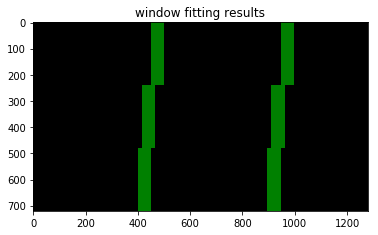

In [8]:
## Lane Lines - this code is not needed for the overall pipeline

warped = masked_image

# window settings
window_width = 50 
#window_height = 80 # Break image into 9 vertical layers since image height is 720
window_height = 240 # Break image into 2 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2

    #l_center = np.argmax(np.convolve(window[:, 0],l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

def image_with_window_centroids(window_centroids, warped, window_width, window_height):

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows     
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    return output
        
output = image_with_window_centroids(window_centroids, warped, window_width, window_height)
    
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

plt.imsave('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/pipeline_images/test4_lines_regions.jpg',output)

In [9]:
### Fit polynomial to both lane lines

binary_warped = warped_im_combined

def give_fits(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return left_fit, right_fit, left_fit_cr, right_fit_cr

#left_fit, right_fit, out_img = give_fits(binary_warped)
left_fit, right_fit, left_fit_cr, right_fit_cr = give_fits(binary_warped)

In [10]:
### Generate x and y values for plotting - READY

def give_fits_points(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

left_fitx, right_fitx, ploty = give_fits_points(binary_warped, left_fit, right_fit)
    
def give_curvature(left_fit_cr, right_fit_cr, ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #take radius at the point closest to the car
    y_eval = np.max(ploty)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = give_curvature(left_fit_cr, right_fit_cr, ploty)

print(left_curverad, 'm', right_curverad, 'm')

66312.9332248 m 648.610662443 m


In [35]:
### Find the lane center

def lane_center_position(left_fit, right_fit, ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.66/700 # meters per pixel in x dimension for the exact position of the vehicle
    #xm_per_pix = 2.8/700 # meters per pixel in x dimension for few meters in front of the vehicle (this is where the lane center is actually estimated since the image is warped)
    
    #take values at the point closest to the car
    y_eval = np.max(ploty)
    
    left_fitx_max = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fitx_max = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
     
    lane_center = int((right_fitx_max - left_fitx_max)/2) + left_fitx_max
    camera_position = image.shape[1]/2
    
    if (lane_center - camera_position > 0):
            leng = 3.66/2 # Assume avg lane width of 3.66 m
            mag = ((lane_center-camera_position)/640.*leng)
            head = ("right", round(mag,2))
    else:
            leng = 3.66/2.
            mag = ((lane_center-camera_position)/640.*leng)*-1
            head = ("left", round(mag,2))
            
    return head

lane_shift_SI = lane_center_position(left_fit, right_fit, ploty)

print(lane_shift_SI[1], 'meters in', lane_shift_SI[0], 'direction')

0.0 meters in right direction


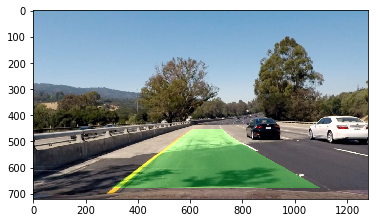

In [25]:
### visualise the final lane

warped = warped_im_combined

def visualise_lane(warped, image, left_fitx, right_fitx, ploty):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result
    
result = visualise_lane(warped, image, left_fitx, right_fitx, ploty)
plt.imshow(result)
plt.imsave('D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/pipeline_images/test4_visualised_lane.jpg',result)

In [37]:
### Test on set of images

imagesNames = os.listdir("test_images/")

dist_pickle = pickle.load( open( "D:/Studies-MOOCs/2017-02_Self-Driving-Car_NanoDegree_Udacity/Self-Driving_Car_PythonCode/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

for imageName in imagesNames:
    
    imageNameShort = imageName[:-4]
    image1 = mpimg.imread((''.join(['test_images/', imageNameShort, '.jpg'])))

    # Step: undistort images
    image2 = cv2.undistort(image1, mtx, dist, None, mtx)
    
    # Step: apply color and gradient pipeline
    image3 = pipeline(image2, s_thresh=(170, 255), h_thresh=(15, 100), l_thresh=(200, 255), sx_thresh=(20, 100))
    
    # Step: Warp the image
    image4, M, Minv = warp(image3)
    image5 = np.zeros_like(image4)
    image5[(image4 > 0)] = 1
    
    # Step: Mask the region of interest
    imshape = image5.shape
    vertices = np.array([[(270,imshape[0]),(280, 0), (imshape[1]-230, 0), (imshape[1]-280,imshape[0])]], dtype=np.int32)
    image6 = region_of_interest(image5, vertices)
        
    # Step: find left and right lines fits
    left_fit, right_fit, left_fit_cr, right_fit_cr = give_fits(image6)
    
    # Step: give fits points for both lines
    left_fitx, right_fitx, ploty = give_fits_points(image6, left_fit, right_fit)
        
    # Step: Visualise Lane
    image7 = visualise_lane(image6,image1, left_fitx, right_fitx, ploty)
    
    # Step: Add curvature and take max
    left_curverad, right_curverad = give_curvature(left_fit_cr, right_fit_cr, ploty)
    #curverad = round(np.max([left_curverad, right_curverad]),0)
    curverad = round((left_curverad+right_curverad)/2)
    
    # Step: Calculate the lane shift
    lane_shift_SI = lane_center_position(left_fit, right_fit, ploty)
        
    # Step: print curvature and lane shift texts on the image
    image8 =cv2.putText(img=np.copy(image7), text=(''.join(['Curvature Radius = ', str(curverad), ' meters'])), org=(100,100),fontFace=5, fontScale=1, color=(255,255,255), thickness=1)
    image9 =cv2.putText(img=np.copy(image8), text=(''.join(['Lane Shift = ', str(lane_shift_SI[1]), ' meters to the ', lane_shift_SI[0]])), org=(100,150),fontFace=5, fontScale=1, color=(255,255,255), thickness=1)
         
    # Step: Save & Write processed images
    cv2.imwrite((''.join(['test_images/', imageNameShort, '_PROCESSED', '.jpg'])), image9)
    
    

In [38]:
### Test on Movie

def process_image(image1):
    
    # Step: undistort images
    image2 = cv2.undistort(image1, mtx, dist, None, mtx)
    
    # Step: apply color and gradient pipeline
    image3 = pipeline(image2, s_thresh=(170, 255), h_thresh=(15, 100), l_thresh=(200, 255), sx_thresh=(20, 100))
    
    # Step: Warp the image
    image4, M, Minv = warp(image3)
    image5 = np.zeros_like(image4)
    image5[(image4 > 0)] = 1
    
    # Step: Mask the region of interest
    imshape = image5.shape
    vertices = np.array([[(270,imshape[0]),(280, 0), (imshape[1]-230, 0), (imshape[1]-280,imshape[0])]], dtype=np.int32)
    image6 = region_of_interest(image5, vertices)
        
    # Step: find left and right lines fits
    left_fit, right_fit, left_fit_cr, right_fit_cr = give_fits(image6)
    
    # Step: give fits points for both lines
    left_fitx, right_fitx, ploty = give_fits_points(image6, left_fit, right_fit)
        
    # Step: Visualise Lane
    image7 = visualise_lane(image6,image1, left_fitx, right_fitx, ploty)
    
    #Step: Add curvature and take max
    left_curverad, right_curverad = give_curvature(left_fit_cr, right_fit_cr, ploty)
    #curverad = round(np.max([left_curverad, right_curverad]),0)
    curverad = round((left_curverad+right_curverad)/2)
    
    # Step: Calculate the lane shift
    lane_shift_SI = lane_center_position(left_fit, right_fit, ploty)
        
    # Step: print curvature and lane shift texts on the image
    image8 =cv2.putText(img=np.copy(image7), text=(''.join(['Curvature Radius = ', str(curverad), ' meters'])), org=(100,100),fontFace=5, fontScale=1, color=(255,255,255), thickness=1)
    image9 =cv2.putText(img=np.copy(image8), text=(''.join(['Lane Shift = ', str(lane_shift_SI[1]), ' meters to the ', lane_shift_SI[0]])), org=(100,150),fontFace=5, fontScale=1, color=(255,255,255), thickness=1)
    
    return image9


In [39]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:43<00:00,  4.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 44s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [48]:
challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:38<00:00,  4.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 39s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
harder_challenge_output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
harder_challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))

In [17]:
my_video_processor_object = MyVideoProcessor()
white_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(my_video_processor_object.process_image_V2)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:38<00:00,  4.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 39s
